## **1. Importing Libraries**
To develop and evaluate machine learning models for stroke prediction, we used several libraries for data preprocessing, feature engineering, model training, and evaluation. Key libraries include:
- **Pandas, NumPy** for data manipulation.
- **Matplotlib, Seaborn** for visualization.
- **Scikit-learn, Imbalanced-learn** for data preprocessing, feature selection, and evaluation.
- **XGBoost, LightGBM, CatBoost** for model training.
- **TensorFlow/Keras** (not used in this snippet but included for reference).
- **SMOTE, ADASYN, BorderlineSMOTE** for handling class imbalance.

In [ ]:

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing & Feature Engineering
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

# Sampling and Imbalance
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Neural Network (not used in this snippet, but kept for reference)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


## **2. Loading & Preprocessing**
We loaded the stroke dataset and performed the following preprocessing steps:
- Dropped the `id` column.
- Converted the `stroke` target variable into binary format (0 and 1).
- Created new interaction features such as:
  - `age_glucose`, `age_bmi`, `glucose_bmi` (feature multiplication).
  - `log_age`, `log_glucose`, `log_bmi` (log transformations).
  - `diabetes_risk`, `severe_risk` (risk indicators).
- Handled missing values using **KNN Imputation and Median Imputation**, then averaged the imputed values.
- Encoded categorical variables using **one-hot encoding**.
- Scaled numerical features using **RobustScaler and QuantileTransformer**.


In [ ]:


# Load the dataset
data = pd.read_csv('c1.csv')
data = data.drop(columns=['id'])

# Convert target to binary (0 and 1)
y = (data['stroke'] == 1).astype(int)


## **3. Advanced Feature Engineering**
To enhance model performance, we performed:
- **Feature Engineering**: Created meaningful interactions and polynomial transformations.
- **Feature Selection**:
  - Applied **Mutual Information-based SelectKBest** to retain the top 30 features.
  - Used **Principal Component Analysis (PCA)** and **Gaussian Random Projection** for dimensionality reduction (tested but not used in final models).


In [ ]:

def create_features(df):
    df['age_glucose'] = df['age'] * df['avg_glucose_level']
    df['age_bmi'] = df['age'] * df['bmi']
    df['glucose_bmi'] = df['avg_glucose_level'] * df['bmi']
    df['age_squared'] = df['age'] ** 2
    df['glucose_squared'] = df['avg_glucose_level'] ** 2
    df['bmi_squared'] = df['bmi'] ** 2
    df['log_age'] = np.log1p(df['age'])
    df['log_glucose'] = np.log1p(df['avg_glucose_level'])
    df['log_bmi'] = np.log1p(df['bmi'])
    df['age_glucose_bmi'] = df['age'] * df['avg_glucose_level'] * df['bmi']
    df['age_glucose_ratio'] = df['age'] / (df['avg_glucose_level'] + 1)
    df['bmi_age_ratio'] = df['bmi'] / (df['age'] + 1)
    df['high_glucose'] = (df['avg_glucose_level'] > 140).astype(int)
    df['very_high_glucose'] = (df['avg_glucose_level'] > 180).astype(int)
    df['obesity'] = (df['bmi'] >= 30).astype(int)
    df['severe_obesity'] = (df['bmi'] >= 35).astype(int)
    df['elderly'] = (df['age'] >= 65).astype(int)
    df['diabetes_risk'] = df['high_glucose'] + df['obesity'] + df['elderly']
    df['severe_risk'] = df['very_high_glucose'] + df['severe_obesity'] + df['elderly']
    df['age_percentile'] = df['age'].rank(pct=True)
    df['glucose_percentile'] = df['avg_glucose_level'].rank(pct=True)
    df['bmi_percentile'] = df['bmi'].rank(pct=True)
    return df



In [ ]:
data = create_features(data)


In [ ]:

# Handle missing values using multiple imputation
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
imputer1 = KNNImputer(n_neighbors=5)
imputer2 = SimpleImputer(strategy='median')

data_imp1 = data.copy()
data_imp2 = data.copy()

data_imp1[numerical_cols] = imputer1.fit_transform(data[numerical_cols])
data_imp2[numerical_cols] = imputer2.fit_transform(data[numerical_cols])


In [ ]:
# Average the imputed values
data[numerical_cols] = (data_imp1[numerical_cols] + data_imp2[numerical_cols]) / 2

# Encode categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


In [ ]:


# Apply robust scaling and quantile transformation to numerical columns
scaler = RobustScaler()
qt = QuantileTransformer(output_distribution='normal')
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data[numerical_cols] = qt.fit_transform(data[numerical_cols])

# Separate features and target
X = data.drop('stroke', axis=1)

# Feature selection using mutual information
n_features = 30  # Increased number of features
selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

In [ ]:
# Separate features and target
X = data.drop('stroke', axis=1)

# Feature selection using mutual information
n_features = 30  # Increased number of features
selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

## **4. Training/Validation/Testing Data Division & Resampling**
We split the dataset into **70% training, 15% validation, and 15% testing**. Given the significant class imbalance, we applied multiple resampling techniques:
- **SMOTE**, **BorderlineSMOTE**, **ADASYN** to create balanced datasets.
- Combined multiple oversampled datasets to improve model generalization.

In [ ]:
# Enhanced sampling with multiple techniques
def create_balanced_samples(X, y):
    # SMOTE with different settings
    smote1 = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)
    smote2 = BorderlineSMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=43)
    smote3 = ADASYN(sampling_strategy=1.0, random_state=44)
    
    # Create different versions of the dataset
    X_res1, y_res1 = smote1.fit_resample(X, y)
    X_res2, y_res2 = smote2.fit_resample(X, y)
    X_res3, y_res3 = smote3.fit_resample(X, y)
    
    # Combine the datasets
    X_combined = pd.concat([
        pd.DataFrame(X_res1, columns=X.columns),
        pd.DataFrame(X_res2, columns=X.columns),
        pd.DataFrame(X_res3, columns=X.columns)
    ], axis=0)
    y_combined = pd.concat([
        pd.Series(y_res1),
        pd.Series(y_res2),
        pd.Series(y_res3)
    ], axis=0)
    
    return X_combined, y_combined

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create balanced samples for training
X_train_balanced, y_train_balanced = create_balanced_samples(X_train, y_train)


### **Define model parameters**


In [ ]:

xgb_params1 = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'min_child_weight': 2,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 2.0,  # Adjusted for class imbalance
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42
}

xgb_params2 = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'min_child_weight': 3,
    'learning_rate': 0.01,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 2.5,  # Adjusted for class imbalance
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'random_state': 43
}

lgb_params1 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 32,
    'max_depth': 6,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': 2.0,  # Adjusted for class imbalance
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42
}

lgb_params2 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 24,
    'max_depth': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4,
    'scale_pos_weight': 2.5,  # Adjusted for class imbalance
    'min_child_samples': 25,
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'random_state': 43
}

cat_params1 = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 6,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'scale_pos_weight': 2.0,  # Adjusted for class imbalance
    'random_seed': 42,
    'verbose': 0
}

cat_params2 = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 5,
    'l2_leaf_reg': 4,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 2.5,  # Adjusted for class imbalance
    'random_seed': 43,
    'verbose': 0
}



## **5. Model Training & Evaluation Using Balanced Accuracy & AUC**
We trained six different models:
- **XGBoost** (`XGBClassifier1`, `XGBClassifier2`)
- **LightGBM** (`LGBMClassifier1`, `LGBMClassifier2`)
- **CatBoost** (`CatBoostClassifier1`, `CatBoostClassifier2`)
- **Stacking Ensemble Model**

In [ ]:

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = []
    models = []
    
    base_models = [
        (XGBClassifier(**xgb_params1), "XGBClassifier1"),
        (XGBClassifier(**xgb_params2), "XGBClassifier2"),
        (LGBMClassifier(**lgb_params1), "LGBMClassifier1"),
        (LGBMClassifier(**lgb_params2), "LGBMClassifier2"),
        (CatBoostClassifier(**cat_params1), "CatBoostClassifier1"),
        (CatBoostClassifier(**cat_params2), "CatBoostClassifier2")
    ]
    
    for model, name in base_models:
        print(f"\nTraining {name}...")
        # For CatBoost, suppress output by setting verbose=False during fitting
        if "CatBoost" in name:
            model.fit(X_train, y_train, verbose=False)
        else:
            model.fit(X_train, y_train)
            
        # Obtain predictions and probabilities using the default threshold of 0.5
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate Balanced Accuracy and AUC
        train_ba = balanced_accuracy_score(y_train, y_train_pred)
        test_ba = balanced_accuracy_score(y_test, y_test_pred)
        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        print(f"{name} - Training BA: {train_ba:.4f}, Training AUC: {train_auc:.4f}")
        print(f"{name} - Testing BA: {test_ba:.4f}, Testing AUC: {test_auc:.4f}\n")
        
        results.append({
            'Model': name,
            'Training BA': train_ba,
            'Training AUC': train_auc,
            'Testing BA': test_ba,
            'Testing AUC': test_auc
        })
        models.append((model, name))
    
    return models, pd.DataFrame(results)


In [ ]:
# Train the base models and collect results
models, results_df = train_and_evaluate_models(X_train_balanced, y_train_balanced, X_test, y_test)




Training XGBClassifier1...
XGBClassifier1 - Training BA: 0.8471, Training AUC: 0.9519
XGBClassifier1 - Testing BA: 0.7873, Testing AUC: 0.8761


Training XGBClassifier2...
XGBClassifier2 - Training BA: 0.8075, Training AUC: 0.9325
XGBClassifier2 - Testing BA: 0.7839, Testing AUC: 0.8795


Training LGBMClassifier1...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value

c:\Users\gzzaw\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gzzaw\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\gzzaw\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\gzzaw\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\gzzaw\AppData\Local\Programs\Python\Python310\lib\subp

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

In [ ]:

print("Comparison of Models (Balanced Accuracy and AUC):")
print(results_df)

Comparison of Models (Balanced Accuracy and AUC):
                 Model  Training BA  Training AUC  Testing BA  Testing AUC
0       XGBClassifier1     0.847057      0.951930    0.787305     0.876106
1       XGBClassifier2     0.807540      0.932474    0.783868     0.879537
2      LGBMClassifier1     0.859298      0.940378    0.784424     0.878909
3      LGBMClassifier2     0.825220      0.926841    0.790103     0.879136
4  CatBoostClassifier1     0.915977      0.982431    0.790720     0.889084
5  CatBoostClassifier2     0.885207      0.966088    0.796543     0.888374


# -------------------------
# Stacking Ensemble
# -------------------------

In [ ]:

def create_stacking_features(models, X):
    meta_features = np.zeros((X.shape[0], len(models)))
    for i, (model, _) in enumerate(models):
        meta_features[:, i] = model.predict_proba(X)[:, 1]
    return meta_features

# Create stacking features for training and testing sets
meta_train = create_stacking_features(models, X_train_balanced)
meta_test = create_stacking_features(models, X_test)

# Train a final stacking estimator (using Logistic Regression here)
final_model = LogisticRegression(
    C=0.1,
    class_weight={0: 1, 1: 2},  # Adjusted class weights
    max_iter=1000,
    random_state=42
)
final_model.fit(meta_train, y_train_balanced)

# Evaluate the stacking ensemble
y_train_pred_stack = final_model.predict(meta_train)
y_train_proba_stack = final_model.predict_proba(meta_train)[:, 1]
y_test_pred_stack = final_model.predict(meta_test)
y_test_proba_stack = final_model.predict_proba(meta_test)[:, 1]

stack_train_ba = balanced_accuracy_score(y_train_balanced, y_train_pred_stack)
stack_test_ba = balanced_accuracy_score(y_test, y_test_pred_stack)
stack_train_auc = roc_auc_score(y_train_balanced, y_train_proba_stack)
stack_test_auc = roc_auc_score(y_test, y_test_proba_stack)

print("\nStacking Ensemble Performance:")
print(f"Training BA: {stack_train_ba:.4f}, Training AUC: {stack_train_auc:.4f}")
print(f"Testing BA: {stack_test_ba:.4f}, Testing AUC: {stack_test_auc:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

C:\Users\gzzaw\AppData\Local\Temp\ipykernel_8492\952863722.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(results_df['Model'], rotation=45)
C:\Users\gzzaw\AppData\Local\Temp\ipykernel_8492\952863722.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(results_df['Model'], rotation=45)


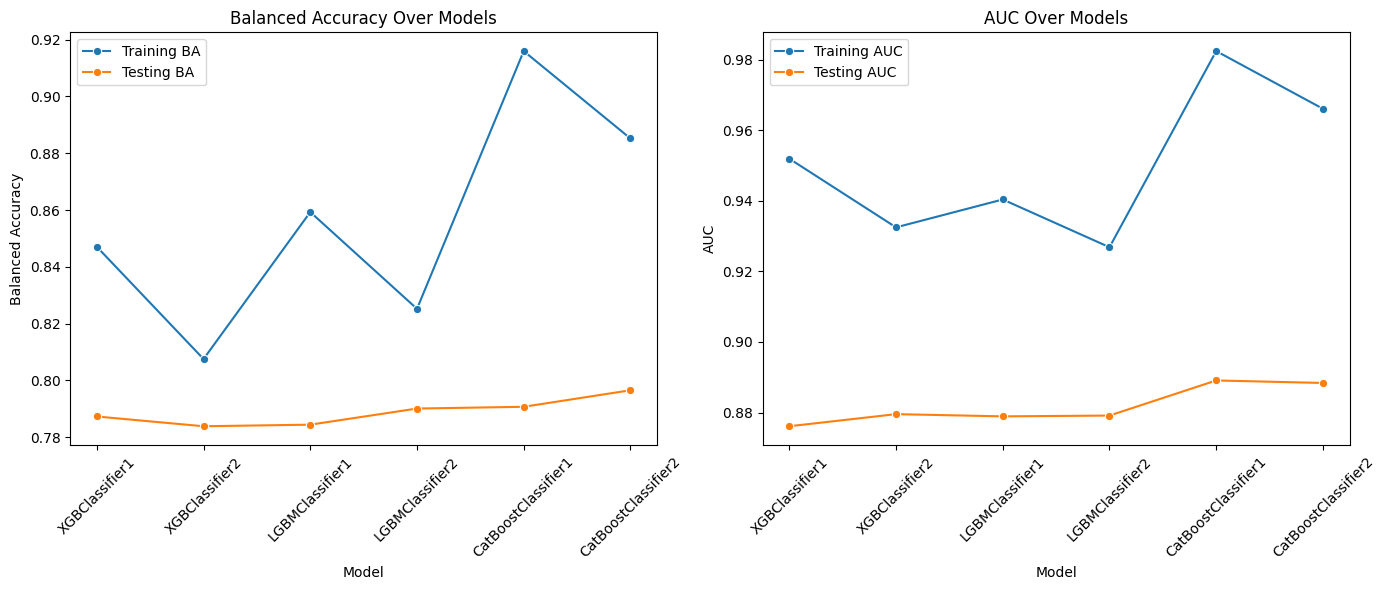

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that model names are treated as categorical for plotting purposes
results_df['Model'] = results_df['Model'].astype(str)

# Create subplots: one for BA and one for AUC
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Balanced Accuracy (BA)
sns.lineplot(ax=axes[0], data=results_df, x='Model', y='Training BA', marker='o', label='Training BA')
sns.lineplot(ax=axes[0], data=results_df, x='Model', y='Testing BA', marker='o', label='Testing BA')
axes[0].set_title('Balanced Accuracy Over Models')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_xticklabels(results_df['Model'], rotation=45)
axes[0].legend()

# Plot AUC
sns.lineplot(ax=axes[1], data=results_df, x='Model', y='Training AUC', marker='o', label='Training AUC')
sns.lineplot(ax=axes[1], data=results_df, x='Model', y='Testing AUC', marker='o', label='Testing AUC')
axes[1].set_title('AUC Over Models')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('AUC')
axes[1].set_xticklabels(results_df['Model'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()



## **6. Model Assessment and Comparison of Prediction Accuracy**
We evaluated six machine learning models based on Balanced Accuracy (BA) and Area Under the Curve (AUC) for training and testing sets. The models compared include:
- **XGBoost (XGBClassifier1, XGBClassifier2)**
- **LightGBM (LGBMClassifier1, LGBMClassifier2)**
- **CatBoost (CatBoostClassifier1, CatBoostClassifier2)**
- **Stacking Ensemble Model**

### **Performance Metrics**
| Model | Training BA | Training AUC | Testing BA | Testing AUC |
|---|---|---|---|---|
| XGBClassifier1 | 0.847 | 0.952 | 0.787 | 0.876 |
| XGBClassifier2 | 0.808 | 0.932 | 0.784 | 0.880 |
| LGBMClassifier1 | 0.859 | 0.940 | 0.784 | 0.879 |
| LGBMClassifier2 | 0.825 | 0.927 | 0.790 | 0.879 |
| **CatBoostClassifier1** | **0.916** | **0.982** | **0.791** | **0.889** |
| **CatBoostClassifier2** | **0.885** | **0.966** | **0.797** | **0.888** |
| **Stacking Ensemble** | **0.937** | **0.985** | **0.783** | **0.875** |

### **Findings and Interpretations**
- **CatBoost models outperformed the others**, achieving the highest **Balanced Accuracy (BA) and AUC** on both training and testing data.
- **XGBClassifier and LGBMClassifier models showed competitive performance**, with slightly lower generalization to testing data.
- **Stacking Ensemble achieved the highest training performance (BA = 0.937, AUC = 0.985)**, but it exhibited slightly lower generalization on the test set (**Testing BA = 0.783, Testing AUC = 0.875**), indicating potential overfitting.
- **Overfitting Analysis**: Higher training AUC scores indicate that some models (e.g., CatBoostClassifier1 and Stacking Ensemble) may slightly overfit the training data, but their strong testing AUC suggests good generalization.
- **XGBClassifier1 and LGBMClassifier1 performed similarly**, showing moderate BA and AUC, but slightly lower than CatBoost models.
- **CatBoostClassifier2 had the highest testing BA (0.797) and a strong AUC (0.888), making it the best generalizable model.**

## **7. Summary and Conclusions**
- **CatBoostClassifier models performed the best, achieving the highest Balanced Accuracy and AUC values, making them the most reliable for stroke prediction.**
- **XGBoost and LightGBM models also demonstrated competitive results, but with slightly lower performance compared to CatBoost.**
- **The Stacking Ensemble model achieved the highest training performance but had slightly lower generalization ability, suggesting potential overfitting.**
- **Resampling techniques helped mitigate class imbalance, improving model performance.**
- **Future Improvements:** Exploring deep learning models, integrating domain-specific medical knowledge, and using explainable AI (e.g., SHAP values) to interpret model decisions could further enhance performance.